In [2]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import glob
from ast import literal_eval
from statistics import mean
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
import matplotlib
print(matplotlib.matplotlib_fname())
print(matplotlib.get_cachedir())

/root/anaconda3/envs/vllm/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc
/root/.cache/matplotlib


##  1. 只画latency

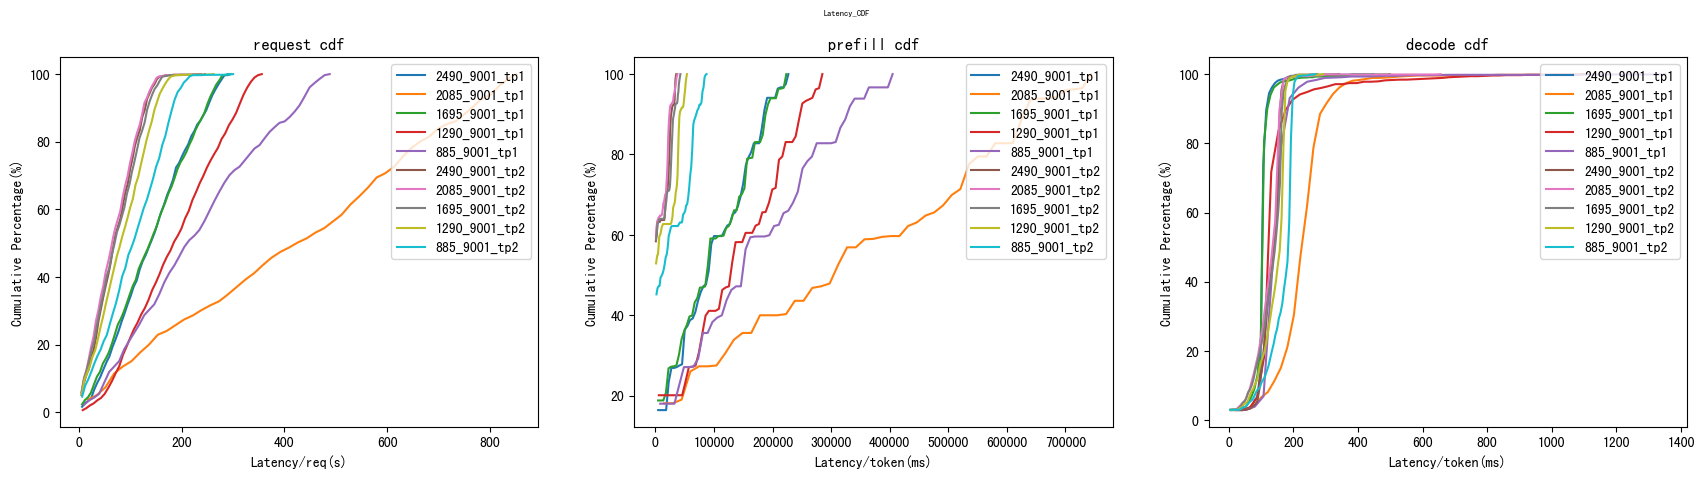

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/llm-serve/Llumnix/logs/l40/benchmark_pdd_tp1_1000_2085_9001_latency_info.json'

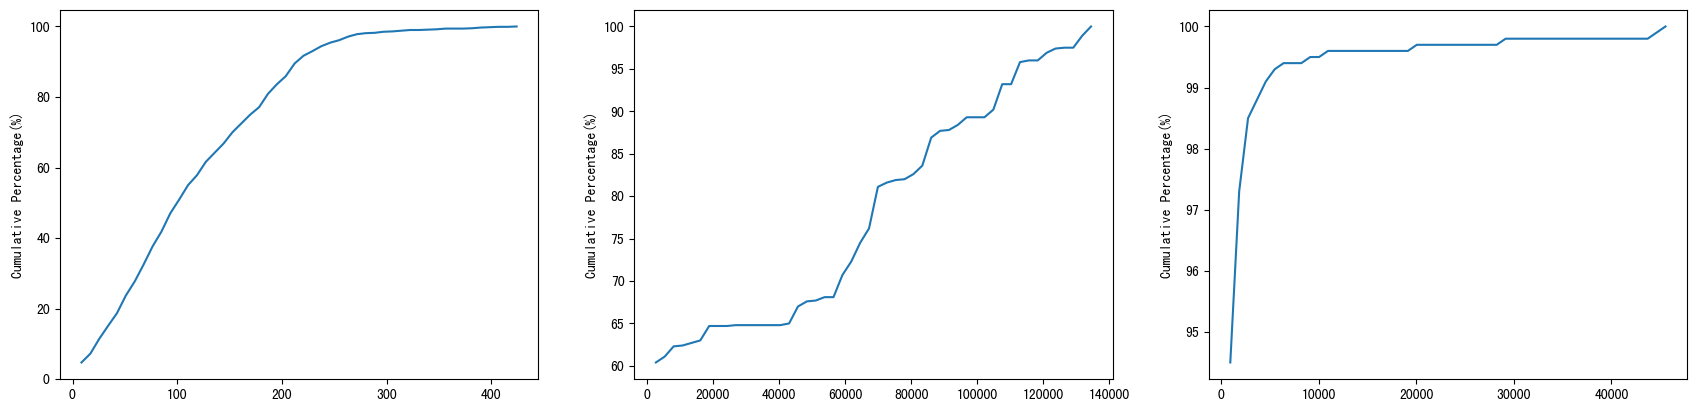

In [9]:
def calculate_cdf(latencies):
    hist, bin_edges = np.histogram(latencies, bins=50)
    cumsum = np.cumsum(hist)
    print("Latency: ")
    print(f"{bin_edges=}")
    print(f"{hist=}")
    print(f"{cumsum=}")

def plot_latency_cdf(log_dir, tps, sm_clocks, mem_clocks, req_num=100, is_pdd=False):
    fig, (ax_req, ax_prefill, ax_decode) = plt.subplots(1, 3, figsize=(3*7, 4.8))
    for tp in tps:
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                if is_pdd:  
                    log_filename = f'benchmark_pdd_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json'
                else:
                    log_filename = f'benchmark_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json'
                latencies = json.load(open(os.path.join(log_dir, log_filename), 'r'))[0]

                req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

                def plot_single(ax, latencies, is_prefill=False):
                    hist, bin_edges = np.histogram(latencies, bins=50)
                    cumsum = np.cumsum(hist)
                    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{sm_clock}_{mem_clock}_tp{tp}')
                    ax.set_ylabel('Cumulative Percentage(%)')
                    # ax.set_legend([f'{sm_clock}_{mem_clock}'])

                plot_single(ax_req, req_latencies)
                plot_single(ax_prefill, prefill_latencies, is_prefill=True)
                plot_single(ax_decode, decode_latencies)
    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

    fig_filename_title = "Latency_CDF"
    plt.suptitle(fig_filename_title, fontsize=6)
    plt.show()
    # fig.savefig(fig_filename_title + ".png")
    
# Read the log file using json
# log_dir = '/workspace/llm-serve/Llumnix/logs/pre-test/result'
# sm_clocks = [1005, 1275, 1500, 2100]
# mem_clocks = [8001]
log_dir = '/workspace/llm-serve/Llumnix/logs/l40'
sm_clocks = ["2490","2085","1695","1290","885"]
# sm_clocks = ["2490",]
mem_clocks = [9001]
tps = [1,2]
req_num = 1000
# log_filename = 'benchmark_1005_8001_tp1_100_latency_info.json'
# latencies = json.load(open(os.path.join(log_dir, log_filename), 'r'))[0]
# print(latencies['request_latencies'])
# plot_latency_cdf(
#     latencies['request_latencies'],
#     latencies['prefill_token_latencies'],
#     latencies['decode_token_latencies'],
#     log_filename
# )
plot_latency_cdf(log_dir,tps,sm_clocks,mem_clocks,req_num,False)
plot_latency_cdf('/workspace/llm-serve/Llumnix/logs/l40',[1],sm_clocks,mem_clocks,req_num,True)


## 2. 将latency和各个metrics放在同一张图

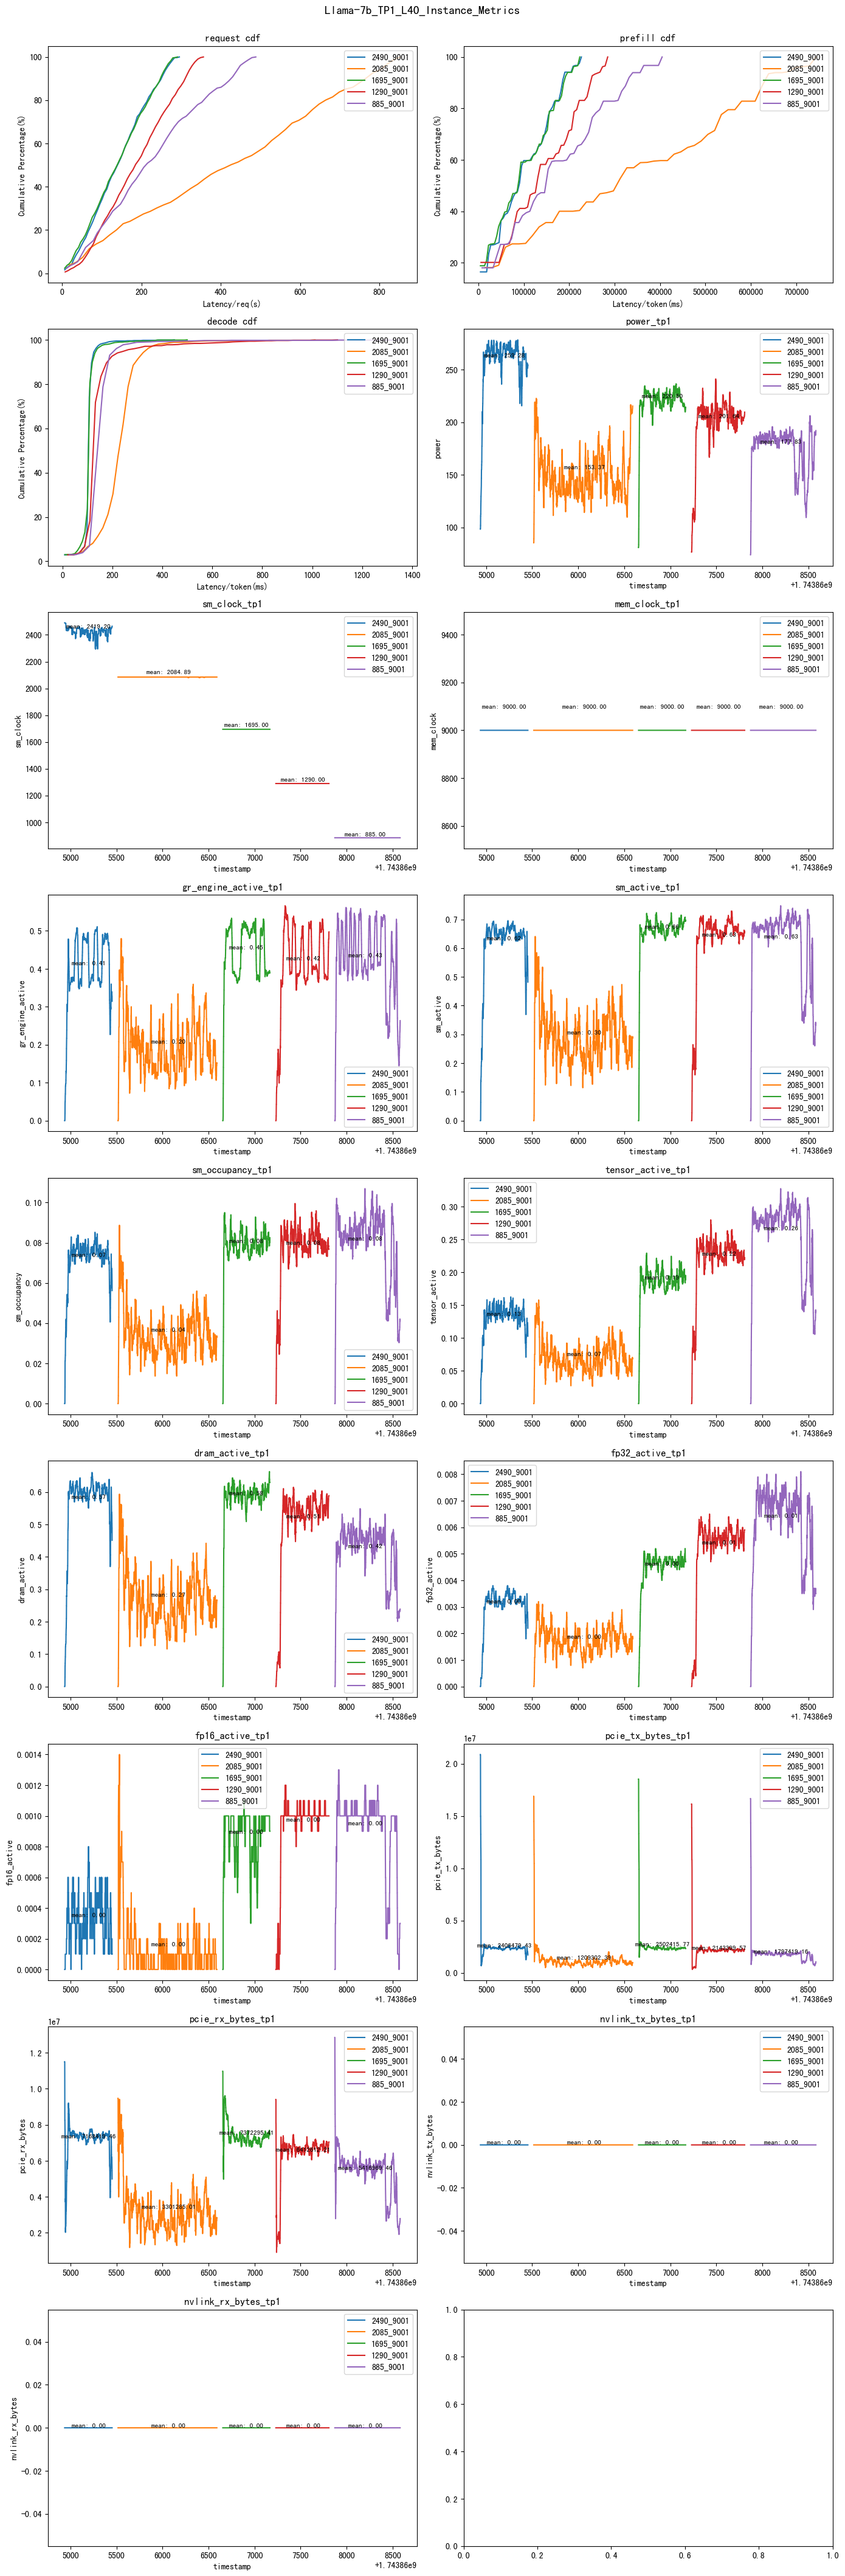

In [11]:
def plot_single(ax, data, sm_clock, mem_clock):
    hist, bin_edges = np.histogram(data, bins=50)
    cumsum = np.cumsum(hist)
    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{sm_clock}_{mem_clock}')
    ax.set_ylabel('Cumulative Percentage(%)')
def plot_latency_cdf(log_dir, tps, sm_clocks, mem_clocks, req_num, axes):
    (ax_req, ax_prefill, ax_decode) = axes
    # 判断tps是不是list，不是就转为list
    if not isinstance(tps, list):
        tps = [tps]
    for tp in tps:
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                log_filename = f'benchmark_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json'
                latencies = json.load(open(os.path.join(log_dir, log_filename), 'r'))[0]

                req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

                plot_single(ax_req, req_latencies, sm_clock, mem_clock)
                plot_single(ax_prefill, prefill_latencies, sm_clock, mem_clock)
                plot_single(ax_decode, decode_latencies, sm_clock, mem_clock)
    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

def plot_instance_log_cdf(log_dir, tps, sm_clocks, mem_clocks, metrics, req_num=100):
    # 根据metrics数设置图的数量，2个图一行
    num_metrics = len(metrics) + 3
    num_rows = (num_metrics + 1) // 2
    
    for tp in tps:
        fig, axes = plt.subplots(num_rows, 2, figsize=(2*7, num_rows*4.8))
        axes = axes.flatten()  # 将二维数组展平为一维数组
        latency_axes = axes[:3]  # 前三个子图用于延迟
        axes = axes[3:]  # 剩余的子图用于其他指标
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                log_filename = f'serve_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_instance.csv'
                instance_log = pd.read_csv(os.path.join(log_dir, log_filename))

                # 删除dispatch_load_metric为-inf的行
                instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
                # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
                for metric in metrics:
                    instance_log[metric] = instance_log[metric].apply(
                        lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
                    )


                    # ax.set_legend([f'{sm_clock}_{mem_clock}'])
                for i, metric in enumerate(metrics):
                    metric_tmp = instance_log[metric]
                    axes[i].plot(instance_log["timestamp"], metric_tmp, label=f'{sm_clock}_{mem_clock}')
                    axes[i].set_ylabel(metric)
                    # 标记均值（具体数值）
                    mean_value = metric_tmp.mean()
                    # axes[i].axhline(mean_value, linestyle='--', label=f'{sm_clock}_{mem_clock} mean')
                    if "timestamp" in instance_log.columns and not instance_log["timestamp"].empty:
                        midpoint_value = instance_log["timestamp"].iloc[len(instance_log["timestamp"]) // 2]
                        # print(midpoint_value)
                    else:
                        print("The timestamp column is either missing or empty.")

                    axes[i].text(midpoint_value, mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)
                    # axes[i].axhline(mean_value, linestyle='--', )
                    # plot_single(axes[i], metric_tmp, sm_clock, mem_clock)
        for i, metric in enumerate(metrics):
            axes[i].set_xlabel("timestamp")
            axes[i].set_ylabel(metric)
            axes[i].set_title(f'{metric}_tp{tp}')
            axes[i].legend()
        # 处理 latencies 三个子图
        plot_latency_cdf(log_dir, tp, sm_clocks, mem_clocks, req_num, latency_axes,)
        fig_filename_title = f"Llama-7b_TP{tp}_L40_Instance_Metrics"
        fig.suptitle(fig_filename_title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        fig.savefig(fig_filename_title + ".png")
        plt.close(fig)
    
gpu_metrics = ["power", "sm_clock","mem_clock","gr_engine_active","sm_active","sm_occupancy","tensor_active","dram_active","fp32_active","fp16_active","pcie_tx_bytes","pcie_rx_bytes","nvlink_tx_bytes","nvlink_rx_bytes",]
    
# log_dir = '/workspace/llm-serve/Llumnix/logs/l40'
log_dir = '/workspace/llm-serve/Llumnix/logs/l40/'
sm_clocks = ["2490","2085","1695","1290","885"]
# sm_clocks = ["2490",]
mem_clocks = [9001]
tps = [1,]
req_num = 1000
# plot_instance_log_cdf(log_dir,[2],sm_clocks,mem_clocks,gpu_metrics,req_num)
plot_instance_log_cdf('/workspace/llm-serve/Llumnix/logs/l40',[1],sm_clocks,mem_clocks,gpu_metrics,req_num)

## 3. PDD

instance_id: ('10cc189848f649c58ff46d0a33e5a8ca',) True


/tmp/ipykernel_3153/2570364909.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instance_log[metric] = instance_log[metric].apply(


instance_id: ('9f6ab83606b7451d8f6ba800c5684879',) False


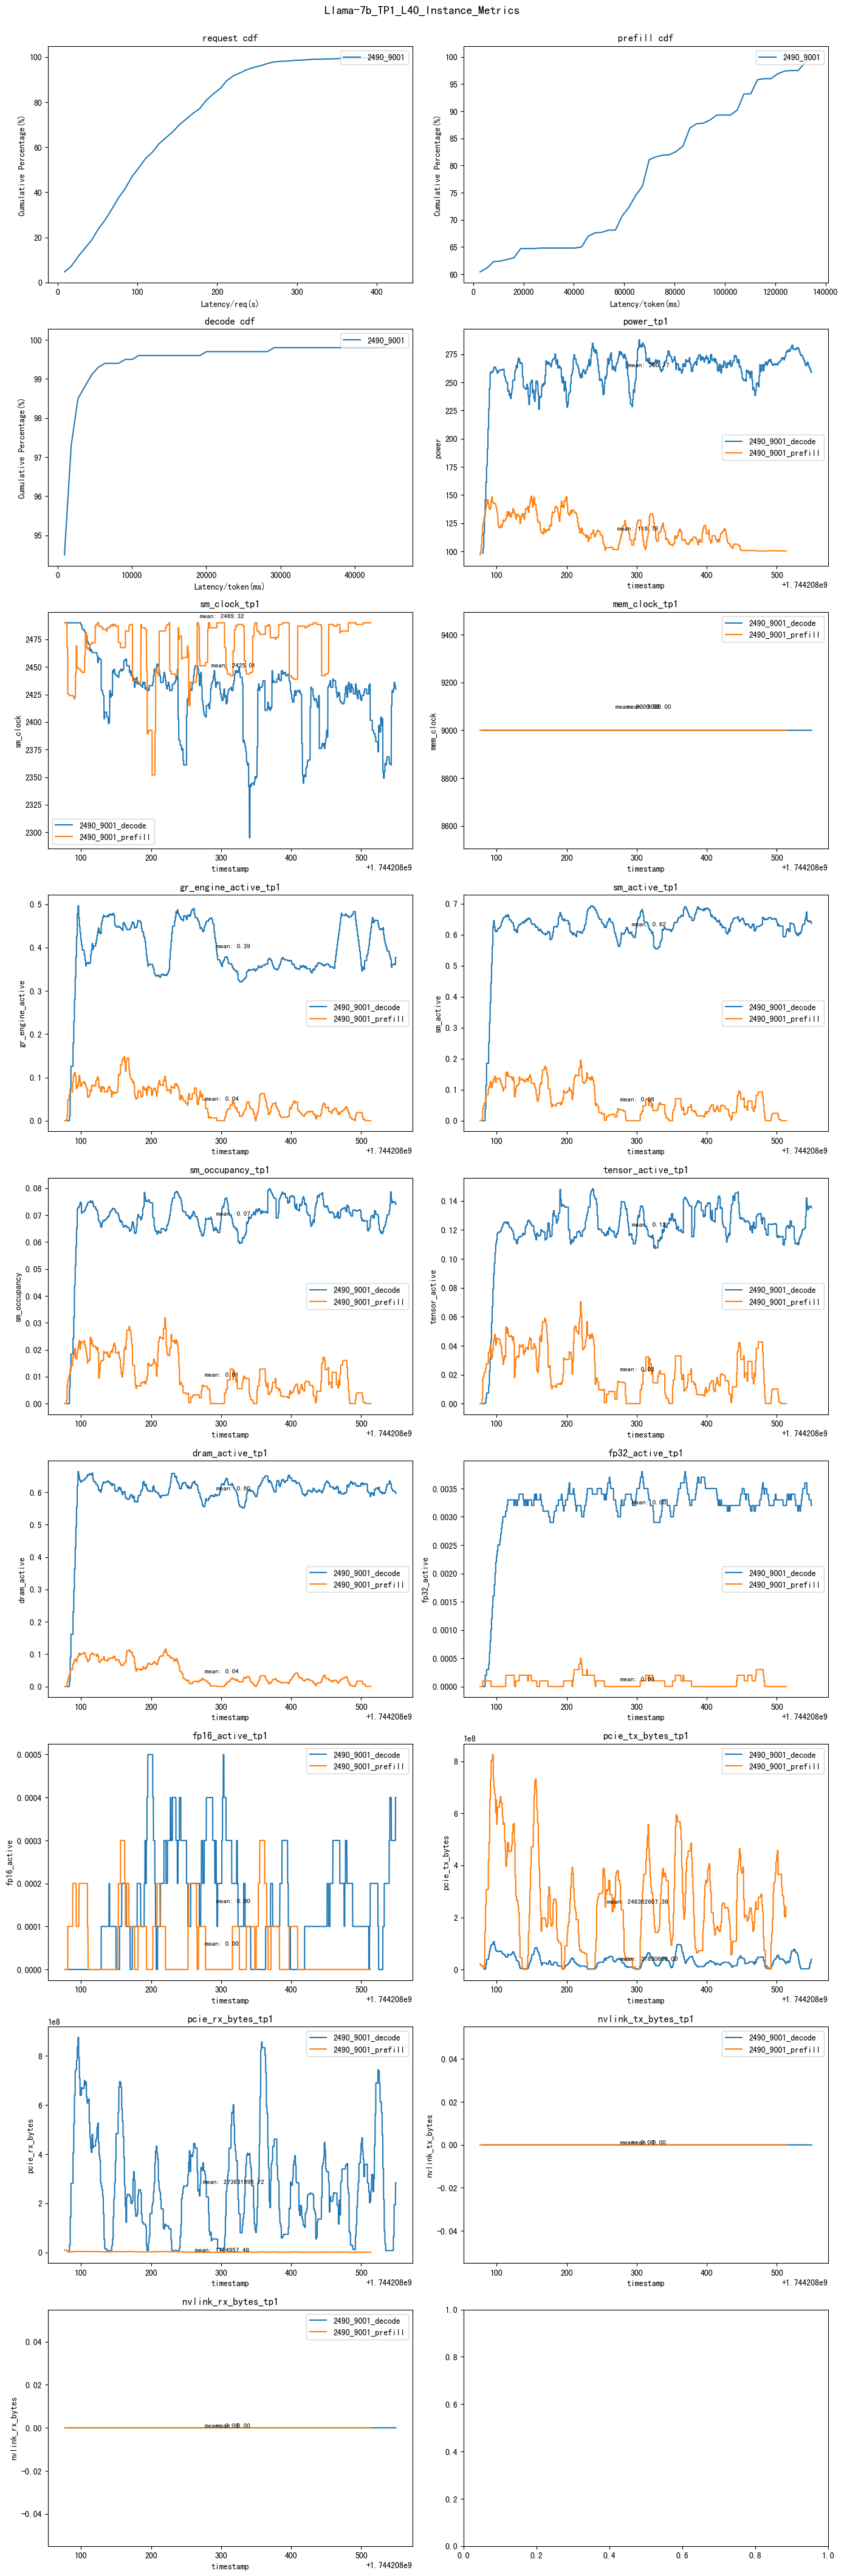

In [4]:
def plot_single(ax, data, sm_clock, mem_clock):
    hist, bin_edges = np.histogram(data, bins=50)
    cumsum = np.cumsum(hist)
    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{sm_clock}_{mem_clock}')
    ax.set_ylabel('Cumulative Percentage(%)')
def plot_latency_cdf(log_dir, tps, sm_clocks, mem_clocks, req_num, axes, is_pdd=False):
    (ax_req, ax_prefill, ax_decode) = axes
    # 判断tps是不是list，不是就转为list
    if not isinstance(tps, list):
        tps = [tps]
    for tp in tps:
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                if is_pdd:
                    log_filename = f'benchmark_pdd_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json'
                else:
                    log_filename = f'benchmark_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json'
                latencies = json.load(open(os.path.join(log_dir, log_filename), 'r'))[0]

                req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

                plot_single(ax_req, req_latencies, sm_clock, mem_clock)
                plot_single(ax_prefill, prefill_latencies, sm_clock, mem_clock)
                plot_single(ax_decode, decode_latencies, sm_clock, mem_clock)
    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

def plot_pdd_instance_log_cdf(log_dir, tps, sm_clocks, mem_clocks, metrics, req_num=100):
    # 根据metrics数设置图的数量，2个图一行
    num_metrics = len(metrics) + 3
    num_rows = (num_metrics + 1) // 2
    
    for tp in tps:
        fig, axes = plt.subplots(num_rows, 2, figsize=(2*7, num_rows*4.8))
        axes = axes.flatten()  # 将二维数组展平为一维数组
        latency_axes = axes[:3]  # 前三个子图用于延迟
        axes = axes[3:]  # 剩余的子图用于其他指标
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                log_filename = f'serve_pdd_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_instance.csv'
                instance_logs_tmp = pd.read_csv(os.path.join(log_dir, log_filename))
                instance_logs = instance_logs_tmp.groupby(["instance_id"])
                for instance_id, instance_log in instance_logs:
                    print(f"instance_id: {instance_id} {'10c' in instance_id[0]}")
                    label_stage = "decode" if "10c" in instance_id[0] else "prefill"
                    # 删除dispatch_load_metric为-inf的行
                    instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
                    # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
                    for metric in metrics:
                        instance_log[metric] = instance_log[metric].apply(
                            lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
                        )


                        # ax.set_legend([f'{sm_clock}_{mem_clock}'])
                    for i, metric in enumerate(metrics):
                        metric_tmp = instance_log[metric]
                        axes[i].plot(instance_log["timestamp"], metric_tmp, label=f'{sm_clock}_{mem_clock}_{label_stage}')
                        axes[i].set_ylabel(metric)
                        # 标记均值（具体数值）
                        mean_value = metric_tmp.mean()
                        # axes[i].axhline(mean_value, linestyle='--', label=f'{sm_clock}_{mem_clock} mean')
                        if "timestamp" in instance_log.columns and not instance_log["timestamp"].empty:
                            midpoint_value = instance_log["timestamp"].iloc[len(instance_log["timestamp"]) // 2]
                            # print(midpoint_value)
                        else:
                            print("The timestamp column is either missing or empty.")

                        axes[i].text(midpoint_value, mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)
                        # axes[i].axhline(mean_value, linestyle='--', )
                        # plot_single(axes[i], metric_tmp, sm_clock, mem_clock)
        for i, metric in enumerate(metrics):
            axes[i].set_xlabel("timestamp")
            axes[i].set_ylabel(metric)
            axes[i].set_title(f'{metric}_tp{tp}')
            axes[i].legend()
        # 处理 latencies 三个子图
        plot_latency_cdf(log_dir, tp, sm_clocks, mem_clocks, req_num, latency_axes, is_pdd=True)
        fig_filename_title = f"Llama-7b_TP{tp}_L40_Instance_Metrics"
        fig.suptitle(fig_filename_title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        fig.savefig(fig_filename_title + ".png")
        plt.close(fig)
    
gpu_metrics = ["power", "sm_clock","mem_clock","gr_engine_active","sm_active","sm_occupancy","tensor_active","dram_active","fp32_active","fp16_active","pcie_tx_bytes","pcie_rx_bytes","nvlink_tx_bytes","nvlink_rx_bytes",]
    
# log_dir = '/workspace/llm-serve/Llumnix/logs/l40'
log_dir = '/workspace/llm-serve/Llumnix/logs/l40/'
# sm_clocks = ["2490","2085","1695","1290","885"]
sm_clocks = ["2490",]
mem_clocks = [9001]
tps = [1,]
req_num = 1000
# plot_instance_log_cdf(log_dir,[2],sm_clocks,mem_clocks,gpu_metrics,req_num)
plot_pdd_instance_log_cdf('/workspace/llm-serve/Llumnix/logs/l40',[1],sm_clocks,mem_clocks,gpu_metrics,req_num)

## 4. 将pdd与非pdd放在同一张图

filename: serve_tp2_1000_2490_9001_instance.csv
filename: serve_pdd_tp1_1000_2490_9001_instance.csv


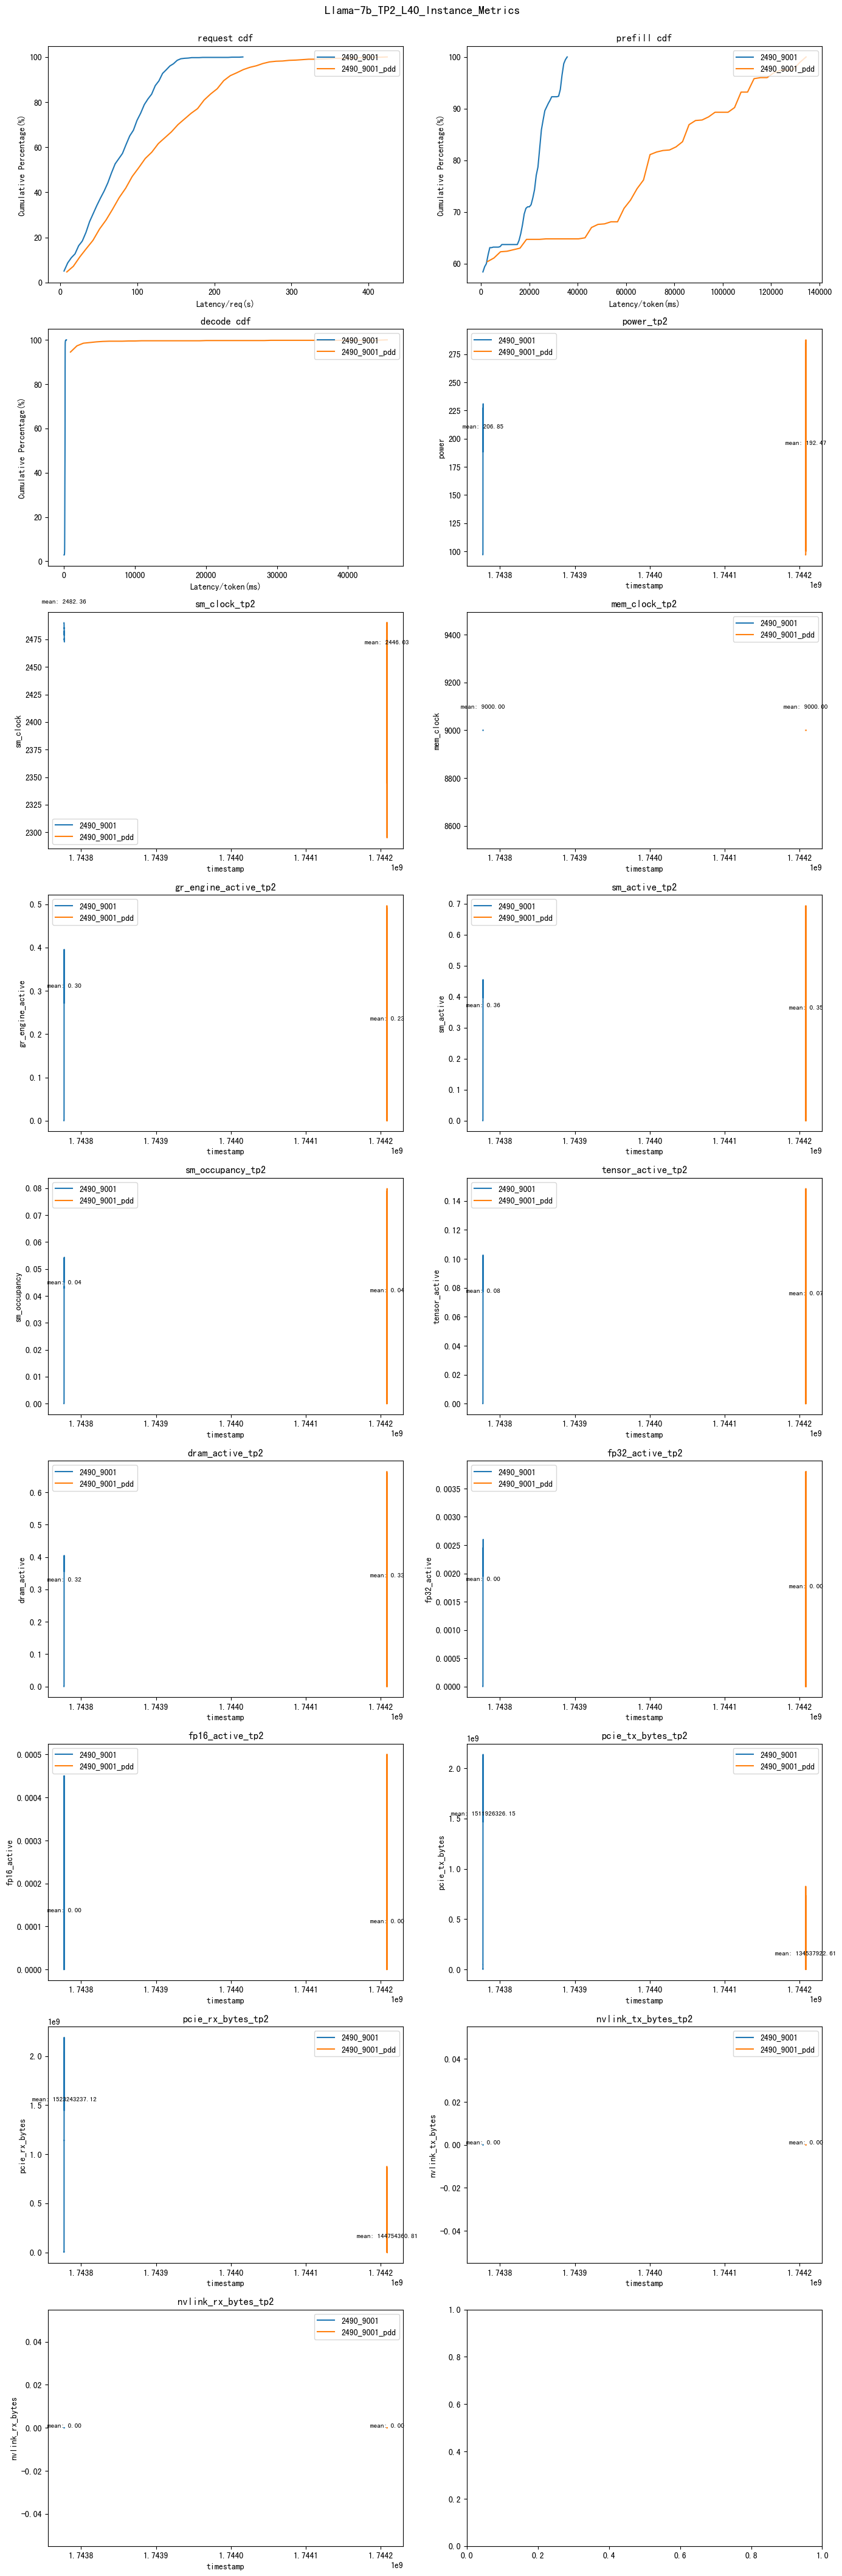

In [5]:
def plot_single(ax, data, sm_clock, mem_clock,is_pdd=False):
    hist, bin_edges = np.histogram(data, bins=50)
    cumsum = np.cumsum(hist)
    if is_pdd:
        ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{sm_clock}_{mem_clock}_pdd')
    else:
        ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{sm_clock}_{mem_clock}')
    ax.set_ylabel('Cumulative Percentage(%)')
def plot_latency_cdf(log_dir, tps, sm_clocks, mem_clocks, req_num, axes):
    (ax_req, ax_prefill, ax_decode) = axes
    # 判断tps是不是list，不是就转为list
    if not isinstance(tps, list):
        tps = [tps]
    for tp in tps:
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                for log_filename in [f'benchmark_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json',f'benchmark_pdd_tp{tp//2}_{req_num}_{sm_clock}_{mem_clock}_latency_info.json',]:

                    latencies = json.load(open(os.path.join(log_dir, log_filename), 'r'))[0]

                    req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

                    plot_single(ax_req, req_latencies, sm_clock, mem_clock, "pdd" in log_filename)
                    plot_single(ax_prefill, prefill_latencies, sm_clock, mem_clock, "pdd" in log_filename)
                    plot_single(ax_decode, decode_latencies, sm_clock, mem_clock, "pdd" in log_filename)
    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

def plot_instance_log_cdf(log_dir, tps, sm_clocks, mem_clocks, metrics, req_num=100):
    # 根据metrics数设置图的数量，2个图一行
    num_metrics = len(metrics) + 3
    num_rows = (num_metrics + 1) // 2
    
    for tp in tps:
        fig, axes = plt.subplots(num_rows, 2, figsize=(2*7, num_rows*4.8))
        axes = axes.flatten()  # 将二维数组展平为一维数组
        latency_axes = axes[:3]  # 前三个子图用于延迟
        axes = axes[3:]  # 剩余的子图用于其他指标
        for sm_clock in sm_clocks:
            for mem_clock in mem_clocks:
                for log_filename in [f'serve_tp{tp}_{req_num}_{sm_clock}_{mem_clock}_instance.csv',f'serve_pdd_tp{tp//2}_{req_num}_{sm_clock}_{mem_clock}_instance.csv',]:
                    print(f"filename: {log_filename}")
                    instance_log = pd.read_csv(os.path.join(log_dir, log_filename))
                    # 删除dispatch_load_metric为-inf的行
                    instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
                    # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
                    for metric in metrics:
                        instance_log[metric] = instance_log[metric].apply(
                            lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
                        )


                        # ax.set_legend([f'{sm_clock}_{mem_clock}'])
                    for i, metric in enumerate(metrics):
                        metric_tmp = instance_log[metric]
                        if "pdd" in log_filename:
                            axes[i].plot(instance_log["timestamp"], metric_tmp, label=f'{sm_clock}_{mem_clock}_pdd')
                        else:
                            axes[i].plot(instance_log["timestamp"], metric_tmp, label=f'{sm_clock}_{mem_clock}')
                        axes[i].set_ylabel(metric)
                        # 标记均值（具体数值）
                        mean_value = metric_tmp.mean()
                        # axes[i].axhline(mean_value, linestyle='--', label=f'{sm_clock}_{mem_clock} mean')
                        axes[i].text(instance_log["timestamp"][len(instance_log["timestamp"])//2], mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)
                        # axes[i].axhline(mean_value, linestyle='--', )
                        # plot_single(axes[i], metric_tmp, sm_clock, mem_clock)
        for i, metric in enumerate(metrics):
            axes[i].set_xlabel("timestamp")
            axes[i].set_ylabel(metric)
            axes[i].set_title(f'{metric}_tp{tp}')
            axes[i].legend()
        # 处理 latencies 三个子图
        plot_latency_cdf(log_dir, tp, sm_clocks, mem_clocks, req_num, latency_axes)
        fig_filename_title = f"Llama-7b_TP{tp}_L40_Instance_Metrics"
        fig.suptitle(fig_filename_title, fontsize=14)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        fig.savefig(fig_filename_title + ".png")
        plt.close(fig)
    
gpu_metrics = ["power", "sm_clock","mem_clock","gr_engine_active","sm_active","sm_occupancy","tensor_active","dram_active","fp32_active","fp16_active","pcie_tx_bytes","pcie_rx_bytes","nvlink_tx_bytes","nvlink_rx_bytes",]
    
# log_dir = '/workspace/llm-serve/Llumnix/logs/l40'
log_dir = '/workspace/llm-serve/Llumnix/logs/l40/'
# sm_clocks = ["2490","2085","1695","1290","885"]
sm_clocks = ["2490",]
mem_clocks = [9001]
tps = [1,]
req_num = 1000
plot_instance_log_cdf(log_dir,[2],sm_clocks,mem_clocks,gpu_metrics,req_num)
# plot_instance_log_cdf('/workspace/llm-serve/Llumnix/logs',[1],sm_clocks,mem_clocks,gpu_metrics,req_num,True)

## pdd

In [6]:
def plot_single(ax, data, label):
    hist, bin_edges = np.histogram(data, bins=50)
    cumsum = np.cumsum(hist)
    ax.plot(bin_edges[1:], cumsum/np.sum(hist)*100, label=f'{label}')
    ax.set_ylabel('Cumulative Percentage(%)')

def plot_latency_according_filename(filename, axes, label):
    print(f"filename: {filename}")
    (ax_req, ax_prefill, ax_decode) = axes
    latencies = json.load(open(filename, 'r'))[0]
    req_latencies, prefill_latencies, decode_latencies = latencies['request_latencies'], latencies['prefill_token_latencies'], latencies['decode_token_latencies']

    plot_single(ax_req, req_latencies, label)
    plot_single(ax_prefill, prefill_latencies, label)
    plot_single(ax_decode, decode_latencies, label)

def plot_latency_cdf(log_dir, tp, instance_num, req_num, axes):
    (ax_req, ax_prefill, ax_decode) = axes

    log_filename = f'benchmark_{instance_num}_tp{tp}_{req_num}_latency_info.json'
    plot_latency_according_filename(os.path.join(log_dir, log_filename), axes, f'{instance_num}-instance')

    for prefill_num in range(1, instance_num):
        decede_num = instance_num - prefill_num
        log_filename = f'benchmark_pdd_tp{tp}_{req_num}_{prefill_num}_{decede_num}_latency_info.json'
        plot_latency_according_filename(os.path.join(log_dir, log_filename), axes, f'{instance_num}-instance-pdd-{prefill_num}-{decede_num}')

    ax_req.set_xlabel('Latency/req(s)')
    ax_req.set_ylabel('Cumulative Percentage(%)')
    ax_req.set_title('request cdf')
    ax_req.legend(loc='upper right')
    ax_prefill.set_xlabel('Latency/token(ms)')
    ax_prefill.set_ylabel('Cumulative Percentage(%)')
    ax_prefill.set_title('prefill cdf')
    ax_prefill.legend(loc='upper right')
    ax_decode.set_xlabel('Latency/token(ms)')
    ax_decode.set_ylabel('Cumulative Percentage(%)')
    ax_decode.set_title('decode cdf')
    ax_decode.legend(loc='upper right')

def plot_metrics_according_filename(filename, metrics, ax, label):
    print(f"filename: {filename}")
    instance_log = pd.read_csv(filename)
    # 删除dispatch_load_metric为-inf的行
    instance_log = instance_log[instance_log['dispatch_load_metric'] != -np.inf]
    # 将某一列中 "[0.0]" 类型的数据转换为 列表均值
    for metric in metrics:
        instance_log[metric] = instance_log[metric].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) == 1 else (mean(literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)
        )

    for i, metric in enumerate(metrics):
        metric_tmp = instance_log[metric]
        ax[i].plot(instance_log["timestamp"], metric_tmp, label=f'{label}')
        ax[i].set_ylabel(metric)
        # 标记均值（具体数值）
        mean_value = metric_tmp.mean()
        ax[i].text(instance_log["timestamp"][len(instance_log["timestamp"])//4], mean_value*1.01, f'mean: {mean_value:.2f}', ha='center', va='bottom', fontsize=8)


def plot_instance_log_cdf(log_dir, model, distribution, tp, instance_num, metrics, req_num=100, qps=None):
    log_dir = os.path.join(log_dir, f'{model}/{distribution}')
    # 根据metrics数设置图的数量，2个图一行
    num_metrics = len(metrics) + 3
    num_rows = (num_metrics + 1) // 2
    
    fig, axes = plt.subplots(num_rows, 2, figsize=(2*7, num_rows*4.8))
    axes = axes.flatten()  # 将二维数组展平为一维数组
    latency_axes = axes[:3]  # 前三个子图用于延迟
    axes = axes[3:]  # 剩余的子图用于其他指标
    
    log_filename = f'serve_{instance_num}_tp{tp}_{req_num}_instance.csv'
    plot_metrics_according_filename(os.path.join(log_dir, log_filename), metrics, axes, f'{instance_num}-instance')

    for prefill_num in range(1, instance_num):
        decede_num = instance_num - prefill_num
        log_filename = f'serve_pdd_tp{tp}_{req_num}_{prefill_num}_{decede_num}_instance.csv'
        plot_metrics_according_filename(os.path.join(log_dir, log_filename), metrics, axes, f'{instance_num}-instance-pdd-{prefill_num}-{decede_num}')

        
    for i, metric in enumerate(metrics):
        axes[i].set_xlabel("timestamp")
        axes[i].set_ylabel(metric)
        axes[i].set_title(f'{metric}_tp{tp}')
        axes[i].legend()

    # 处理 latencies 三个子图
    plot_latency_cdf(log_dir, tp, instance_num, req_num, latency_axes)
    fig_filename_title = f"{model}-{distribution}-tp_{tp}-instanceNum_{instance_num}_L40_Instance_Metrics"
    fig.suptitle(fig_filename_title, fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    fig.savefig(fig_filename_title + ".png")
    plt.close(fig)
    


filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/serve_4_tp1_1000_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/serve_pdd_tp1_1000_1_3_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/serve_pdd_tp1_1000_2_2_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/serve_pdd_tp1_1000_3_1_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/benchmark_4_tp1_1000_latency_info.json
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/benchmark_pdd_tp1_1000_1_3_latency_info.json
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/benchmark_pdd_tp1_1000_2_2_latency_info.json
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-4/llama-2-7b/poisson/benchmark_pdd_tp1_1000_3_1_latency_info.json


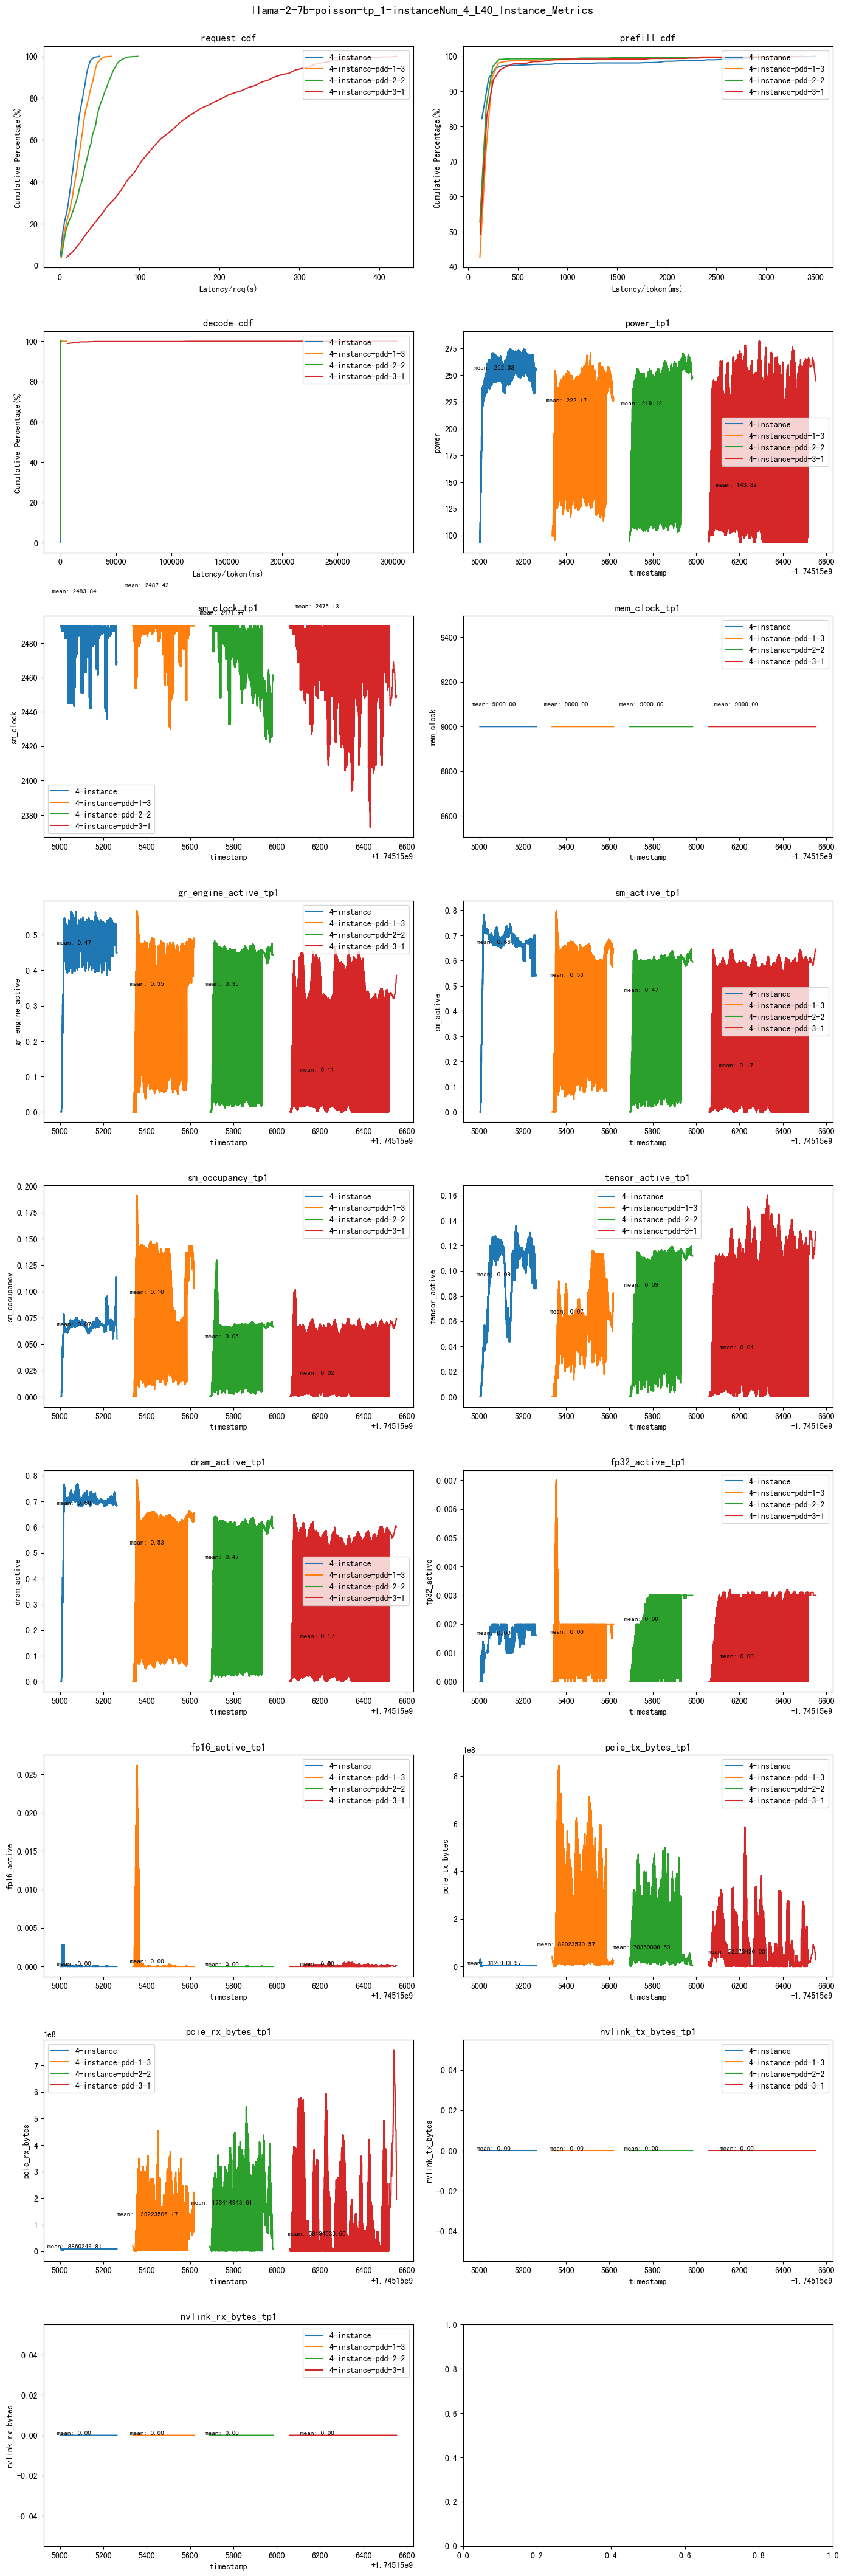

In [9]:
gpu_metrics = ["power", "sm_clock","mem_clock","gr_engine_active","sm_active","sm_occupancy","tensor_active","dram_active","fp32_active","fp16_active","pcie_tx_bytes","pcie_rx_bytes","nvlink_tx_bytes","nvlink_rx_bytes",]
model='llama-2-7b'
distribution= 'poisson'       # 'poisson' "uniform" 
sm_clocks = ["2490",]
mem_clocks = [9001]
tp = 1
instance_num = 4
req_num = 1000
log_dir = f'/workspace/llm-serve/Llumnix/logs/l40-pdd-{instance_num}'
plot_instance_log_cdf(log_dir,model,distribution,tp,instance_num,gpu_metrics,req_num)
# plot_instance_log_cdf('/workspace/llm-serve/Llumnix/logs',[1],sm_clocks,mem_clocks,gpu_metrics,req_num,True)

filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-2/llama-2-7b/poisson/serve_2_tp1_1000_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-2/llama-2-7b/poisson/serve_pdd_tp1_1000_1_1_instance.csv
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-2/llama-2-7b/poisson/benchmark_2_tp1_1000_latency_info.json
filename: /workspace/llm-serve/Llumnix/logs/l40-pdd-2/llama-2-7b/poisson/benchmark_pdd_tp1_1000_1_1_latency_info.json


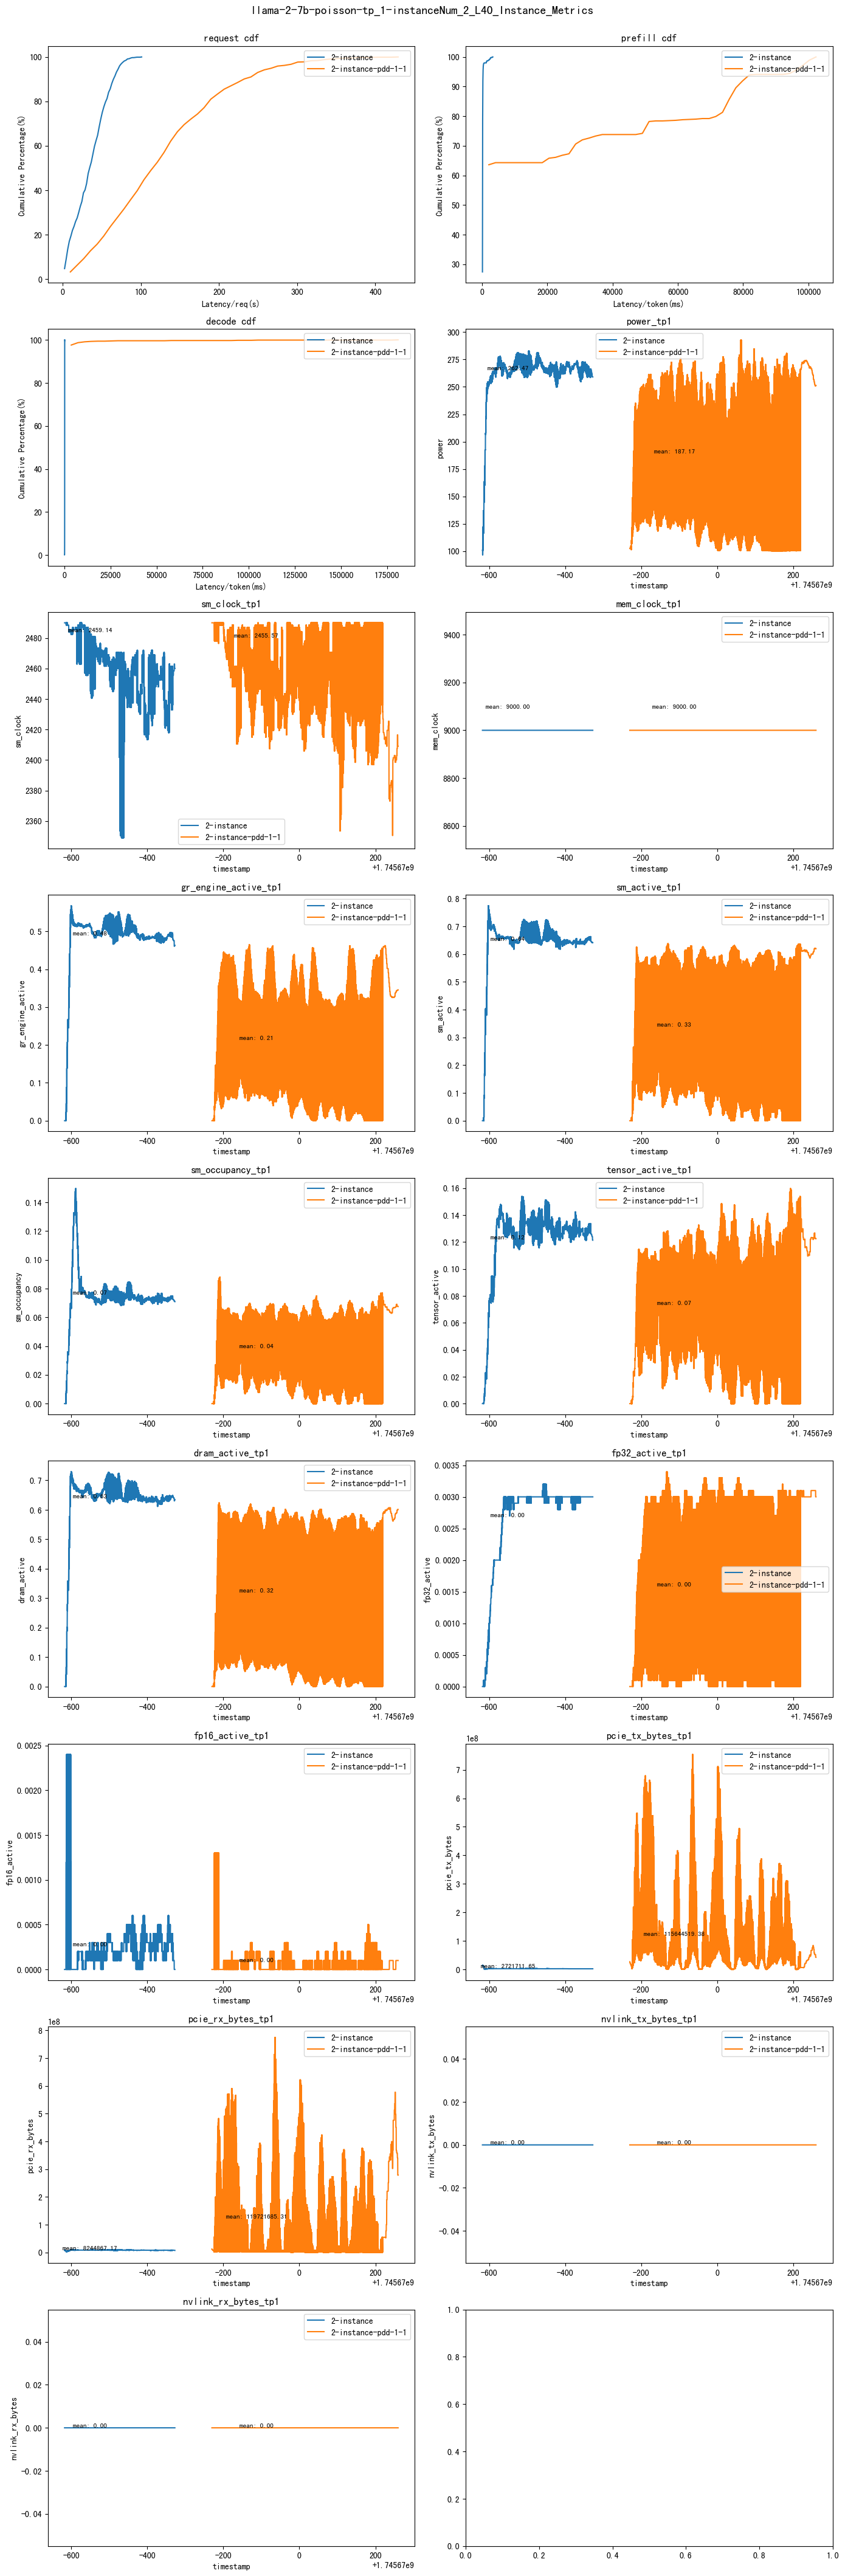

In [8]:

distribution='poisson'
plot_instance_log_cdf(log_dir,model,distribution,tp,instance_num,gpu_metrics,req_num)